# Movie Recommendation System

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise import Reader
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
# importing csv and converting into datframe
movies_df = pd.read_csv('movies.csv')
links_df = pd.read_csv('links.csv', index_col='movieId')
ratings_df = pd.read_csv('ratings.csv')
tags_df = pd.read_csv('tags.csv', index_col='movieId')

In [3]:
# checking shape of all dataframes
print ('small movies df shape:', movies_df.shape)
print ('small links df shape:' , links_df.shape)
print ('small ratings df shape:' , ratings_df.shape)
print ('small tags df shape:' , tags_df.shape)

small movies df shape: (9742, 3)
small links df shape: (9742, 2)
small ratings df shape: (100836, 4)
small tags df shape: (3683, 3)


## Exploratory Data Analysis

In [4]:
#exploring movies dataframe
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# exploring ratings dataframe
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [54]:
ratings_df.drop(columns=['timestamp'],inplace = True)

In [6]:
# merging movie and ratings dataframes
movieratings_df = pd.merge(movies_df,ratings_df)

In [7]:
#exploring the newly merged dataframe
movieratings_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [8]:
# grouped by movieid and explored the average rating for each movie
mr_mean_df = pd.DataFrame(movieratings_df.groupby(['movieId'])['rating'].mean())
mr_mean_df.head()

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


In [9]:
# wanted to explore how many reviews a movie recieved
mr_mean_df['rating_counts'] = movieratings_df.groupby(['movieId'])['rating'].count()
ratingabove_3 = mr_mean_df[(mr_mean_df['rating']>=4) & (mr_mean_df['rating_counts']>=20)]
ratingabove_3.sort_values('rating', ascending = False).head()

,rating,rating_counts
movieId,,
1104,4.475000,20
318,4.429022,317
922,4.333333,27
898,4.310345,29
1204,4.300000,45


Text(0.5, 1.0, 'Average Ratings')

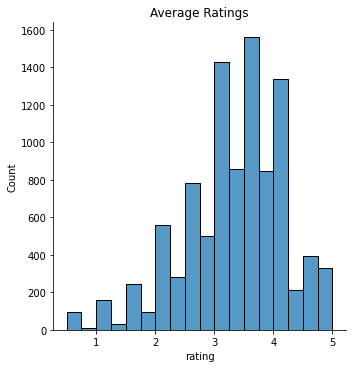

In [10]:
# Visualizing average ratings of the movies
sns.displot(mr_mean_df, x="rating", binwidth=.25)

plt.title('Average Ratings')

Text(0.5, 1.0, 'Rating Counts')

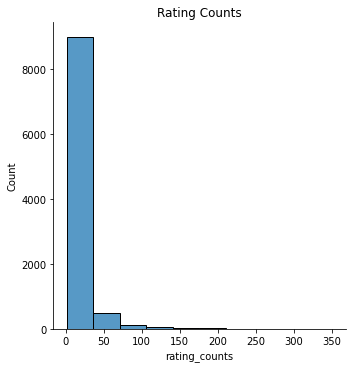

In [11]:
# visualizing the how many counts most movies recieved
sns.displot(mr_mean_df, x="rating_counts", binwidth=35)
plt.title('Rating Counts')

<Figure size 720x576 with 0 Axes>

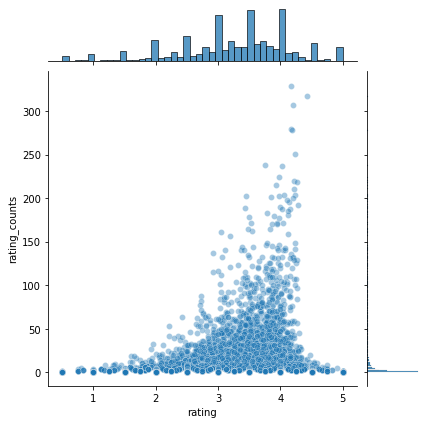

In [12]:
# visualizing what movies may be the most popular
plt.figure(figsize=(10,8))
sns.jointplot(x='rating', y='rating_counts', data=mr_mean_df, alpha=0.4)

## Implenting Surprise

In [13]:
# we want to prep the data so we can convert into a surprise dataset
movieratings_df.drop(columns=['timestamp','title','genres'], inplace = True)

In [14]:
movieratings_df.head()

,movieId,userId,rating
0,1,1,4.0
1,1,5,4.0
2,1,7,4.5
3,1,15,2.5
4,1,17,4.5


In [15]:
#creating a reader and converting panda df into surprise df
reader = Reader(rating_scale=(1, 5))
userRatings_data=Dataset.load_from_df(movieratings_df[['userId','movieId','rating']],reader)


## Train Test Split with Surprise

In [16]:
# train test splitting surprise data with 30% as our test size
trainset, testset = train_test_split(userRatings_data, test_size=0.3)

In [17]:
# checking if our pd df was converter to surprise dataset
print('Type trainset :',type(trainset),'\n')
print('Type testset :',type(testset))

Type trainset : <class 'surprise.trainset.Trainset'> 

Type testset : <class 'list'>


## KNN Models

In [177]:
sim_pearson = {'name':'pearson_baseline', 'user_based':False}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9218
0.9217715435111483


In [173]:
sim_cos = {'name':'cosine','user_based': True}
knn_means = knns.KNNWithMeans(sim_options=sim_cos)
knn_means.fit(trainset)
predictions = knn_means.test(testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9027
0.902703930697039


In [38]:
cv_knn_means = cross_validate(knn_means,userRatings_data)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [39]:
for i in cv_knn_means.items():
    print(i)

np.mean(cv_knn_means['test_rmse'])

('test_rmse', array([0.90990925, 0.89928898, 0.90466494, 0.89830506, 0.90984265]))
('test_mae', array([0.69084895, 0.6843285 , 0.68596888, 0.68388447, 0.69228481]))
('fit_time', (61.30627775192261, 47.830435037612915, 41.9146523475647, 46.35543203353882, 46.99141979217529))
('test_time', (11.974875926971436, 10.972724914550781, 10.961604833602905, 12.93898606300354, 10.705803871154785))


0.9044021764822974

In [40]:
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8820
0.8819797217757692


In [41]:
cv_knn_baseline = cross_validate(knn_baseline,userRatings_data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [42]:
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([0.87840213, 0.87978852, 0.87759935, 0.87723983, 0.88325169]))
('test_mae', array([0.67533322, 0.67522229, 0.67287939, 0.67519945, 0.68120058]))
('fit_time', (58.260895013809204, 45.376805782318115, 46.34543514251709, 43.11526703834534, 48.33119010925293))
('test_time', (11.206993103027344, 12.1321280002594, 11.818595170974731, 11.281761884689331, 13.198665857315063))


0.8792563044156945

## SVD Model

In [43]:
svd = SVD(n_factors=100, n_epochs=50, lr_all=0.007, reg_all=0.5)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.8830
0.8829690078723783


In [44]:
user_34_prediction = svd.predict(5, 1)
user_34_prediction

Prediction(uid=5, iid=1, r_ui=None, est=3.7582975391395346, details={'was_impossible': False})

## GridSearch for best SVD Params

In [ ]:
param_grid = {
    'n_factors':[5, 10,20, 25],
    'n_epochs': [5, 10, 20], 
    'lr_all': [0.002, 0.005, 0.006],
    'reg_all': [0.4, 0.6, .8]}

In [ ]:
gs_model = GridSearchCV(algo_class = SVD,param_grid = param_grid,n_jobs = -1,joblib_verbose = 5)

In [ ]:
gs_model.fit(userRatings_data)

In [ ]:
gs_model.best_params

## Refitting SVD Model With Best Params

In [28]:
svd = SVD(n_factors=10, n_epochs=20, lr_all=0.006, reg_all=0.4)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.8830
0.8829634387156646


## Top 5 Recommendations

In [99]:
def movie_rater(movies_df,num, genre=None):
    userID = 0
    rating_list = []
    while num > 0:
        if genre:
            movie = movies_df[movies_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movies_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list      

In [100]:
user_rating = movie_rater(movies_df, 6, 'Comedy')

      movieId           title         genres
4226     6153  Zapped! (1982)  Comedy|Sci-Fi
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
      movieId                             title         genres
2492     3326  What Planet Are You From? (2000)  Comedy|Sci-Fi
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
      movieId                                              title  genres
5860    32666  National Lampoon's Lady Killers (National Lamp...  Comedy
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
     movieId                title          genres
203      237  Forget Paris (1995)  Comedy|Romance
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
      movieId           title        genres
7571    85881  Win Win (2011)  Comedy|Drama
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
      movieId                                          

In [101]:
user_rating

[{'userId': 0, 'movieId': 6153, 'rating': '3'},
 {'userId': 0, 'movieId': 3326, 'rating': '3'},
 {'userId': 0, 'movieId': 32666, 'rating': '3'},
 {'userId': 0, 'movieId': 237, 'rating': '4'},
 {'userId': 0, 'movieId': 85881, 'rating': '4'},
 {'userId': 0, 'movieId': 7888, 'rating': '4'}]

In [167]:
new_ratings_df = ratings_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [168]:
list_of_movies = []
for m_id in ratings_df['movieId'].unique():
    list_of_movies.append((m_id,svd.predict(1000,m_id)[3]))

In [169]:
svd_ = SVD(n_factors=10, n_epochs=20, lr_all=0.006, reg_all=0.4)
svd_.fit(new_data.build_full_trainset())

In [170]:
for m_id in ratings_df['movieId'].unique():
    list_of_movies.append((m_id,svd_.predict(1000,m_id)[3]))

In [171]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [172]:
ranked_movies

[(3030, 4.32611611152247),
 (6460, 4.258822605498358),
 (6818, 4.2575552071661935),
 (213, 4.236694460819666),
 (3451, 4.234954247320957),
 (26810, 4.22886223505204),
 (177593, 4.22616859984454),
 (158966, 4.21506775147612),
 (2202, 4.214774727182959),
 (3266, 4.210043048907754),
 (8477, 4.2086148688897955),
 (7121, 4.20064464331217),
 (80906, 4.186169762115799),
 (27156, 4.180792665491133),
 (174053, 4.180280820688317),
 (51931, 4.178862647387152),
 (2239, 4.169834631672868),
 (187, 4.165543325808774),
 (3200, 4.158028859150997),
 (3201, 4.157501090858945),
 (1046, 4.153152948269593),
 (3451, 4.1495380987936),
 (3022, 4.148909736265847),
 (6442, 4.146777980993765),
 (1178, 4.143586542531297),
 (2131, 4.143190944152283),
 (1204, 4.143184409237324),
 (25771, 4.137526481627266),
 (1104, 4.133209620399892),
 (318, 4.132039345076283),
 (98154, 4.130619497386597),
 (86345, 4.129276709062175),
 (3037, 4.125803029263737),
 (53, 4.119033081748856),
 (1104, 4.1170544999630865),
 (177593, 4.1142

In [159]:
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
                title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
                print('Recommendation # ', idx+1, ': ', title, '\n')
                n-= 1
                if n == 0:
                    break

In [161]:
recommended_movies(ranked_movies,movies_df,5)

Recommendation #  1 :  2283    Yojimbo (1961)
Name: title, dtype: object 

Recommendation #  2 :  4396    Trial, The (Procès, Le) (1962)
Name: title, dtype: object 

Recommendation #  3 :  4590    Come and See (Idi i smotri) (1985)
Name: title, dtype: object 

Recommendation #  4 :  181    Burnt by the Sun (Utomlyonnye solntsem) (1994)
Name: title, dtype: object 

Recommendation #  5 :  2582    Guess Who's Coming to Dinner (1967)
Name: title, dtype: object 



In [149]:
# def get_movie_recommendation(movie_name):
#     n_movies_to_reccomend = 10
#     movie_list = movies_df[movies_df['title'].str.contains(movie_name)]  
#     if len(movie_list):        
#         movie_idx= movie_list.iloc[0]['movieId']
#         movie_idx = new_data[new_data['movieId'] == movie_idx].index[0]
#         distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
#         rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
#         recommend_frame = []
#         for val in rec_movie_indices:
#             movie_idx = new_data.iloc[val[0]]['movieId']
#             idx = movies[movies['movieId'] == movie_idx].index
#             recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
#         df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
#         return df
#     else:
#         return "No movies found. Please check your input"
    